
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 2 <br>
<font color=696880 size=4>
    Armin Ghojehzadeh 

____

# 🔴 **Import Libs**

In [1]:
!pip uninstall torchtext -y
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install --upgrade torchdata
!pip install --upgrade torchtext --index-url https://download.pytorch.org/whl/cu118
!pip install torchmetrics

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.3/838.3 MB 2.0 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 74.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 83.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 57.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 60.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.2 MB/s eta 0:00:00:00:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.9 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 10.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 25.6 MB/s eta 0:00:0000:01m00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext
import torchdata

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

In [3]:
!python --version
print(torch.__version__)
print(torchtext.__version__)
print(torchdata.__version__)

Python 3.10.12
2.2.0+cu118
0.17.0+cpu
0.7.1


In [4]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 2.2.0+cu118
torchtext --> 0.17.0+cpu
tqdm --> 4.66.5


# 🔴 **Utils**

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [7]:
from datasets import load_dataset

dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']
print(train_data[1]) 

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

{'text': ' = Valkyria Chronicles III = \n'}


## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [8]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def yield_tokens(dataset_split):
    for example in dataset_split:
        yield tokenizer(example["text"])

train_tokens = yield_tokens(train_data)

vocab = build_vocab_from_iterator(train_tokens, specials=["<unk>", "<pad>", "<bos>", "<eos>"])
vocab.set_default_index(vocab["<unk>"])

print("Special Tokens and Their Indices:")
print(f"<unk>: {vocab['<unk>']}")
print(f"<pad>: {vocab['<pad>']}")
print(f"<bos>: {vocab['<bos>']}")
print(f"<eos>: {vocab['<eos>']}")


sample_text = "This is an example sentence."
tokenized_text = tokenizer(sample_text)
indexed_text = [vocab[token] for token in tokenized_text]

print("\nTokenized Text:", tokenized_text)
print("Indexed Text:", indexed_text)

Special Tokens and Their Indices:
<unk>: 0
<pad>: 1
<bos>: 2
<eos>: 3

Tokenized Text: ['this', 'is', 'an', 'example', 'sentence', '.']
Indexed Text: [38, 26, 33, 619, 2140, 6]


## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [9]:
def calculate_statistics(dataset_split):
    num_documents = len(dataset_split)
    total_words = 0
    total_lengths = []

    for doc in dataset_split:
        tokens = tokenizer(doc["text"])
        total_words += len(tokens)
        total_lengths.append(len(tokens))

    avg_doc_length = total_words / num_documents if num_documents > 0 else 0

    return {
        "num_documents": num_documents,
        "total_words": total_words,
        "avg_doc_length": avg_doc_length,
        "min_doc_length": min(total_lengths) if total_lengths else 0,
        "max_doc_length": max(total_lengths) if total_lengths else 0,
    }

train_stats = calculate_statistics(train_data)
print("Training Set Statistics:")
for stat, value in train_stats.items():
    print(f"{stat}: {value}")

Training Set Statistics:
num_documents: 36718
total_words: 2051665
avg_doc_length: 55.87627321749551
min_doc_length: 0
max_doc_length: 696


### 🟡 Analyze the most common and least common words in the dataset.

In [10]:
from collections import Counter

def count_words(dataset_split):
    word_counter = Counter()

    for doc in dataset_split:
        tokens = tokenizer(doc["text"])
        word_counter.update(tokens)

    return word_counter

train_word_counts = count_words(train_data)
most_common_words = train_word_counts.most_common(10)
least_common_words = [word for word, count in train_word_counts.items() if count == 1]

print("Most Common Words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

print("\nNumber of Least Common Words (occurring once):", len(least_common_words))
print("Example of Least Common Words:", least_common_words[:10])


Most Common Words:
the: 130770
,: 102624
.: 84291
of: 57032
and: 50736
in: 45018
to: 39522
a: 36564
=: 29570
was: 21008

Number of Least Common Words (occurring once): 26924
Example of Least Common Words: ['calamaty', 'forgiving', 'unvoiced', 'scanned', 'boosts', 'depleting', 'reila', 'shocktroopers', 'thereon', 'altaha']


### 🟡  Please proceed with further exploration of the dataset. what do you suggest?

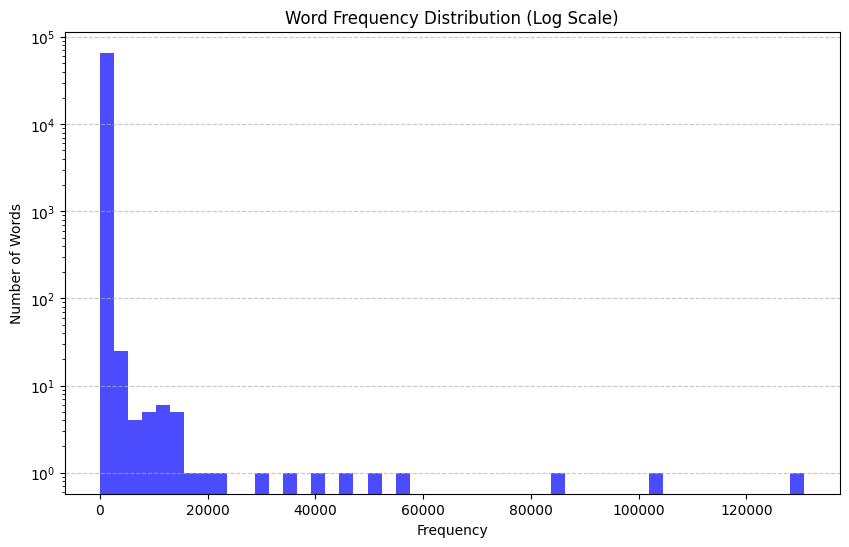

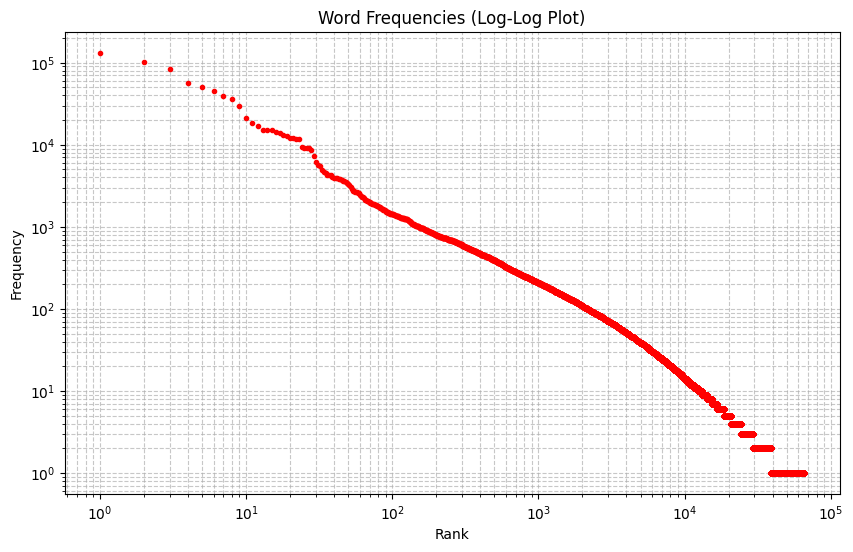

In [11]:
word_frequencies = np.array(list(train_word_counts.values()))

plt.figure(figsize=(10, 6))
plt.hist(word_frequencies, bins=50, log=True, color='blue', alpha=0.7)
plt.title("Word Frequency Distribution (Log Scale)")
plt.xlabel("Frequency")
plt.ylabel("Number of Words")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

sorted_frequencies = np.sort(word_frequencies)[::-1]
ranks = np.arange(1, len(sorted_frequencies) + 1)

plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_frequencies, marker="o", linestyle="", markersize=3, color='red')
plt.title("Word Frequencies (Log-Log Plot)")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.grid(which='both', linestyle='--', alpha=0.7)
plt.show()

## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [12]:
from torch.nn.utils.rnn import pad_sequence

def data_process(raw_text_iter, batch_size, seq_len, vocab, tokenizer):
    tokens = []
    for line in raw_text_iter:
        tokens.extend(tokenizer(line))
    
    token_indices = torch.tensor([vocab[token] for token in tokens if token in vocab])
    
    total_tokens = len(token_indices)
    num_samples = total_tokens // seq_len
    token_indices = token_indices[:num_samples * seq_len]
    data = token_indices.clone().detach().view(num_samples, seq_len)

    inputs = data[:, :-1]
    targets = data[:, 1:]
    return inputs, targets

In [13]:
batch_size = 32
seq_len = 50

train_raw_iter = (line["text"] for line in train_data)
val_raw_iter = (line["text"] for line in val_data)
test_raw_iter = (line["text"] for line in test_data)

train_inputs, train_targets = data_process(train_raw_iter, batch_size, seq_len, vocab, tokenizer)
val_inputs, val_targets = data_process(val_raw_iter, batch_size, seq_len, vocab, tokenizer)
test_inputs, test_targets = data_process(test_raw_iter, batch_size, seq_len, vocab, tokenizer)

print("Inputs shape (N x B x L):", train_inputs.shape)
print("Targets shape (N x B x L):", train_targets.shape)


Inputs shape (N x B x L): torch.Size([41033, 49])
Targets shape (N x B x L): torch.Size([41033, 49])


## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [14]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]


In [15]:
train_dataset = LanguageModelDataset(train_inputs, train_targets)
val_dataset = LanguageModelDataset(val_inputs, val_targets)
test_dataset = LanguageModelDataset(test_inputs, test_targets)

print(f"Dataset length: {len(train_dataset)}")
print("Sample input-target pair:")
print(train_dataset[0])

Dataset length: 41033
Sample input-target pair:
(tensor([   12,  3874,  3890,   885,    12, 20488,    86,  3874,    90, 24097,
         3890,    24,   785, 29473,     5,  6081,     6,  3874,     7,     4,
         5054,    90,    23,     5,  1840,  1016,    10,    17,  3874,  3890,
          885,   634,   980,     5,    26,    11,  5692,   303,    15,   578,
          235,    70,   456,    22, 14003,     8,   758,     6,  2476]), tensor([ 3874,  3890,   885,    12, 20488,    86,  3874,    90, 24097,  3890,
           24,   785, 29473,     5,  6081,     6,  3874,     7,     4,  5054,
           90,    23,     5,  1840,  1016,    10,    17,  3874,  3890,   885,
          634,   980,     5,    26,    11,  5692,   303,    15,   578,   235,
           70,   456,    22, 14003,     8,   758,     6,  2476,    20]))


## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [16]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [17]:
class LanguageModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super(LanguageModel, self).__init__()
      
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(
        input_size=embedding_dim,
        hidden_size=hidden_dim,
        num_layers=num_layers,
        dropout=dropout_rate,
        batch_first=True
    )
    self.fc = nn.Linear(hidden_dim, vocab_size)
    self.dropout = nn.Dropout(dropout_rate)
    

  def forward(self, src):
    embedded = self.embedding(src)
    lstm_out, _ = self.lstm(embedded)
    lstm_out = self.dropout(lstm_out)
    output = self.fc(lstm_out)
    return output

In [18]:
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout_rate = 0.5

model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)
print(model)

src, _ = next(iter(train_loader))
output = model(src)
print("Output shape:", output.shape)

LanguageModel(
  (embedding): Embedding(66061, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=66061, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Output shape: torch.Size([32, 49, 66061])


# 🔴 **Config**

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [20]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
accuracy = tm.Accuracy(task="multiclass", num_classes=vocab_size).to(device)
perplexity = tm.text.Perplexity().to(device)

print("Model Summary:")
print(model)
print(f"Optimizer: {optimizer}")
print(f"Loss Function: {criterion}")
print(f"Metric: {perplexity}")

Model Summary:
LanguageModel(
  (embedding): Embedding(66061, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=66061, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Loss Function: CrossEntropyLoss()
Metric: Perplexity()


# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [21]:
scaler = torch.cuda.amp.GradScaler()

def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
        
      outputs_2d = outputs.view(-1, outputs.size(-1))  
      targets_2d = targets.view(-1)

      loss = loss_fn(outputs_2d, targets_2d)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
        
      logit = F.log_softmax(outputs, dim=-1)
      metric.update(logit, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [22]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
        
      outputs_2d = outputs.view(-1, outputs.size(-1))  
      targets_2d = targets.view(-1) 

      loss = loss_fn(outputs_2d, targets_2d)
      loss_eval.update(loss.item(), n=len(targets))

      logit = F.log_softmax(outputs, dim=-1)
      metric.update(logit, targets)

  return loss_eval.avg, metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [23]:
model = model.to(device)
model.eval()

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  
  outputs_2d = outputs.view(-1, outputs.size(-1))  
  targets_2d = targets.view(-1) 
    
  print(outputs.shape, targets.shape)
    
  loss = criterion(outputs_2d, targets_2d)

print(loss)

torch.Size([32, 49, 66061]) torch.Size([32, 49])
tensor(11.1023, device='cuda:0')


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [24]:
model = model.to(device)

In [25]:
train_subset = torch.utils.data.Subset(train_dataset, indices=range(256))
train_subset_loader = DataLoader(train_subset, batch_size=32, shuffle=True)

In [26]:
num_epochs = 30

for epoch in range(num_epochs):
  model, train_loss, train_perplexity = train_one_epoch(model, train_subset_loader, criterion, optimizer, perplexity, epoch)
  val_loss, val_perplexity = evaluate(model, val_loader, criterion, perplexity)

  print(f"Epoch {epoch} -- Train Loss: {train_loss:.4f} -- Train Perplexity: {train_perplexity:.4f} -- Val Loss: {val_loss:.4f} -- Val Perplexity: {val_perplexity:.4f}")

100%|██████████| 8/8 [00:00<00:00, 15.63batch/s, loss=11, metric=5.87e+4]  


Epoch 0 -- Train Loss: 10.9796 -- Train Perplexity: 58662.7305 -- Val Loss: 10.3496 -- Val Perplexity: 31242.9863


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 18.06batch/s, loss=8.81, metric=6.72e+3]


Epoch 1 -- Train Loss: 8.8125 -- Train Perplexity: 6717.7954 -- Val Loss: 8.0623 -- Val Perplexity: 3172.6475


Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 17.89batch/s, loss=7, metric=1.1e+3]    


Epoch 2 -- Train Loss: 7.0010 -- Train Perplexity: 1097.7565 -- Val Loss: 8.0854 -- Val Perplexity: 3246.8286


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 17.91batch/s, loss=6.74, metric=847]


Epoch 3 -- Train Loss: 6.7412 -- Train Perplexity: 846.5417 -- Val Loss: 8.3302 -- Val Perplexity: 4147.1646


Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 17.78batch/s, loss=6.63, metric=756]


Epoch 4 -- Train Loss: 6.6287 -- Train Perplexity: 756.4730 -- Val Loss: 8.4115 -- Val Perplexity: 4498.5933


Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 17.95batch/s, loss=6.56, metric=707]


Epoch 5 -- Train Loss: 6.5608 -- Train Perplexity: 706.8360 -- Val Loss: 8.4536 -- Val Perplexity: 4692.0225


Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 17.91batch/s, loss=6.51, metric=673]


Epoch 6 -- Train Loss: 6.5122 -- Train Perplexity: 673.2935 -- Val Loss: 8.4725 -- Val Perplexity: 4781.6860


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 17.91batch/s, loss=6.49, metric=659]


Epoch 7 -- Train Loss: 6.4909 -- Train Perplexity: 659.1431 -- Val Loss: 8.4919 -- Val Perplexity: 4875.1265


Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 17.96batch/s, loss=6.47, metric=647]


Epoch 8 -- Train Loss: 6.4729 -- Train Perplexity: 647.3608 -- Val Loss: 8.5110 -- Val Perplexity: 4969.2847


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 17.81batch/s, loss=6.46, metric=640]


Epoch 9 -- Train Loss: 6.4620 -- Train Perplexity: 640.3672 -- Val Loss: 8.5382 -- Val Perplexity: 5106.3418


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.01batch/s, loss=6.45, metric=634]


Epoch 10 -- Train Loss: 6.4519 -- Train Perplexity: 633.9297 -- Val Loss: 8.5589 -- Val Perplexity: 5213.0229


Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 17.55batch/s, loss=6.44, metric=628]


Epoch 11 -- Train Loss: 6.4433 -- Train Perplexity: 628.4805 -- Val Loss: 8.5849 -- Val Perplexity: 5350.0532


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 17.74batch/s, loss=6.44, metric=624]


Epoch 12 -- Train Loss: 6.4360 -- Train Perplexity: 623.8986 -- Val Loss: 8.6101 -- Val Perplexity: 5486.6133


Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 18.05batch/s, loss=6.43, metric=622]


Epoch 13 -- Train Loss: 6.4331 -- Train Perplexity: 622.1159 -- Val Loss: 8.6371 -- Val Perplexity: 5636.8257


Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 18.00batch/s, loss=6.43, metric=619]


Epoch 14 -- Train Loss: 6.4274 -- Train Perplexity: 618.5577 -- Val Loss: 8.6525 -- Val Perplexity: 5724.6206


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 17.88batch/s, loss=6.42, metric=615]


Epoch 15 -- Train Loss: 6.4212 -- Train Perplexity: 614.7153 -- Val Loss: 8.6716 -- Val Perplexity: 5834.9468


Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 17.87batch/s, loss=6.41, metric=611]


Epoch 16 -- Train Loss: 6.4144 -- Train Perplexity: 610.5587 -- Val Loss: 8.6938 -- Val Perplexity: 5965.7578


Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 17.79batch/s, loss=6.4, metric=599] 


Epoch 17 -- Train Loss: 6.3952 -- Train Perplexity: 598.9929 -- Val Loss: 8.7107 -- Val Perplexity: 6067.5811


Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 17.90batch/s, loss=6.4, metric=602] 


Epoch 18 -- Train Loss: 6.4006 -- Train Perplexity: 602.1950 -- Val Loss: 8.7345 -- Val Perplexity: 6213.6143


Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.11batch/s, loss=6.4, metric=600] 


Epoch 19 -- Train Loss: 6.3961 -- Train Perplexity: 599.5196 -- Val Loss: 8.7491 -- Val Perplexity: 6305.2437


Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 18.09batch/s, loss=6.39, metric=597]


Epoch 20 -- Train Loss: 6.3923 -- Train Perplexity: 597.2393 -- Val Loss: 8.7677 -- Val Perplexity: 6423.5234


Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 17.74batch/s, loss=6.39, metric=597]


Epoch 21 -- Train Loss: 6.3917 -- Train Perplexity: 596.8666 -- Val Loss: 8.7855 -- Val Perplexity: 6538.6392


Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 17.69batch/s, loss=6.39, metric=593]


Epoch 22 -- Train Loss: 6.3859 -- Train Perplexity: 593.4067 -- Val Loss: 8.8015 -- Val Perplexity: 6644.2686


Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 17.81batch/s, loss=6.38, metric=592]


Epoch 23 -- Train Loss: 6.3835 -- Train Perplexity: 592.0145 -- Val Loss: 8.8170 -- Val Perplexity: 6748.0186


Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 17.93batch/s, loss=6.37, metric=586]


Epoch 24 -- Train Loss: 6.3730 -- Train Perplexity: 585.8094 -- Val Loss: 8.8288 -- Val Perplexity: 6827.9399


Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 18.09batch/s, loss=6.36, metric=580]


Epoch 25 -- Train Loss: 6.3632 -- Train Perplexity: 580.1245 -- Val Loss: 8.8420 -- Val Perplexity: 6918.8364


Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 18.15batch/s, loss=6.37, metric=585]


Epoch 26 -- Train Loss: 6.3720 -- Train Perplexity: 585.2016 -- Val Loss: 8.8611 -- Val Perplexity: 7052.4795


Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 17.95batch/s, loss=6.36, metric=580]


Epoch 27 -- Train Loss: 6.3626 -- Train Perplexity: 579.7755 -- Val Loss: 8.8761 -- Val Perplexity: 7158.7324


Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 17.85batch/s, loss=6.35, metric=574]


Epoch 28 -- Train Loss: 6.3525 -- Train Perplexity: 573.9117 -- Val Loss: 8.8852 -- Val Perplexity: 7224.1870


Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 17.78batch/s, loss=6.36, metric=576]


Epoch 29 -- Train Loss: 6.3569 -- Train Perplexity: 576.4559 -- Val Loss: 8.8965 -- Val Perplexity: 7306.6260


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [27]:
num_epochs = 10

for lr in [1e-2, 1e-3, 1e-4]:
  print(f'LR={lr}')

  model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()
  perplexity = tm.text.Perplexity().to(device)

  for epoch in range(num_epochs):
    model, train_loss, train_perplexity = train_one_epoch(model, train_loader, criterion, optimizer, perplexity, epoch)
    val_loss, val_perplexity = evaluate(model, val_loader, criterion, perplexity)

    print(f"Epoch {epoch} -- Train Loss: {train_loss:.4f} -- Train Perplexity: {train_perplexity:.4f} -- Val Loss: {val_loss:.4f} -- Val Perplexity: {val_perplexity:.4f}")

  print(f"Val Perplexity: {val_perplexity:.4f}")

LR=0.01


100%|██████████| 1283/1283 [01:05<00:00, 19.48batch/s, loss=11, metric=5.85e+4] 


Epoch 0 -- Train Loss: 10.9765 -- Train Perplexity: 58485.2656 -- Val Loss: 10.7744 -- Val Perplexity: 47779.4141


Epoch 1: 100%|██████████| 1283/1283 [01:07<00:00, 19.04batch/s, loss=9.7, metric=1.62e+4] 


Epoch 1 -- Train Loss: 9.6957 -- Train Perplexity: 16247.6025 -- Val Loss: 8.6424 -- Val Perplexity: 5666.8965


Epoch 2: 100%|██████████| 1283/1283 [01:07<00:00, 19.05batch/s, loss=8.55, metric=5.16e+3]


Epoch 2 -- Train Loss: 8.5488 -- Train Perplexity: 5160.3389 -- Val Loss: 8.2050 -- Val Perplexity: 3659.2112


Epoch 3: 100%|██████████| 1283/1283 [01:07<00:00, 19.05batch/s, loss=8.29, metric=3.97e+3]


Epoch 3 -- Train Loss: 8.2873 -- Train Perplexity: 3973.1724 -- Val Loss: 8.0094 -- Val Perplexity: 3009.1438


Epoch 4: 100%|██████████| 1283/1283 [01:07<00:00, 19.03batch/s, loss=8.13, metric=3.39e+3]


Epoch 4 -- Train Loss: 8.1293 -- Train Perplexity: 3392.5864 -- Val Loss: 7.8702 -- Val Perplexity: 2618.0735


Epoch 5: 100%|██████████| 1283/1283 [01:07<00:00, 19.02batch/s, loss=8.01, metric=3.02e+3]


Epoch 5 -- Train Loss: 8.0144 -- Train Perplexity: 3024.0688 -- Val Loss: 7.7615 -- Val Perplexity: 2348.5017


Epoch 6: 100%|██████████| 1283/1283 [01:07<00:00, 19.02batch/s, loss=7.92, metric=2.76e+3]


Epoch 6 -- Train Loss: 7.9246 -- Train Perplexity: 2764.3745 -- Val Loss: 7.6747 -- Val Perplexity: 2153.1577


Epoch 7: 100%|██████████| 1283/1283 [01:07<00:00, 19.03batch/s, loss=7.85, metric=2.57e+3]


Epoch 7 -- Train Loss: 7.8515 -- Train Perplexity: 2569.6240 -- Val Loss: 7.6037 -- Val Perplexity: 2005.5209


Epoch 8: 100%|██████████| 1283/1283 [01:07<00:00, 19.05batch/s, loss=7.79, metric=2.42e+3]


Epoch 8 -- Train Loss: 7.7911 -- Train Perplexity: 2418.9551 -- Val Loss: 7.5453 -- Val Perplexity: 1891.8888


Epoch 9: 100%|██████████| 1283/1283 [01:07<00:00, 19.03batch/s, loss=7.74, metric=2.3e+3]


Epoch 9 -- Train Loss: 7.7391 -- Train Perplexity: 2296.4846 -- Val Loss: 7.4951 -- Val Perplexity: 1799.1274
Val Perplexity: 1799.1274
LR=0.001


100%|██████████| 1283/1283 [01:05<00:00, 19.51batch/s, loss=11.1, metric=6.62e+4]


Epoch 0 -- Train Loss: 11.0999 -- Train Perplexity: 66165.3828 -- Val Loss: 11.0885 -- Val Perplexity: 65416.0508


Epoch 1: 100%|██████████| 1283/1283 [01:07<00:00, 19.05batch/s, loss=11.1, metric=6.48e+4]


Epoch 1 -- Train Loss: 11.0789 -- Train Perplexity: 64791.2070 -- Val Loss: 11.0663 -- Val Perplexity: 63976.3633


Epoch 2: 100%|██████████| 1283/1283 [01:07<00:00, 19.07batch/s, loss=11.1, metric=6.34e+4]


Epoch 2 -- Train Loss: 11.0575 -- Train Perplexity: 63420.6445 -- Val Loss: 11.0433 -- Val Perplexity: 62524.9961


Epoch 3: 100%|██████████| 1283/1283 [01:07<00:00, 19.07batch/s, loss=11, metric=6.2e+4] 


Epoch 3 -- Train Loss: 11.0353 -- Train Perplexity: 62025.2227 -- Val Loss: 11.0192 -- Val Perplexity: 61034.7930


Epoch 5: 100%|██████████| 1283/1283 [01:07<00:00, 19.06batch/s, loss=11, metric=5.9e+4] 


Epoch 5 -- Train Loss: 10.9859 -- Train Perplexity: 59034.4883 -- Val Loss: 10.9646 -- Val Perplexity: 57789.9414


Epoch 6: 100%|██████████| 1283/1283 [01:07<00:00, 19.05batch/s, loss=11, metric=5.74e+4]


Epoch 6 -- Train Loss: 10.9570 -- Train Perplexity: 57356.0820 -- Val Loss: 10.9318 -- Val Perplexity: 55925.2500


Epoch 7: 100%|██████████| 1283/1283 [01:07<00:00, 19.03batch/s, loss=10.9, metric=5.55e+4]


Epoch 7 -- Train Loss: 10.9233 -- Train Perplexity: 55453.0625 -- Val Loss: 10.8926 -- Val Perplexity: 53775.3047


Epoch 8: 100%|██████████| 1283/1283 [01:07<00:00, 19.04batch/s, loss=10.9, metric=5.32e+4]


Epoch 8 -- Train Loss: 10.8820 -- Train Perplexity: 53207.3750 -- Val Loss: 10.8429 -- Val Perplexity: 51170.0547


Epoch 9: 100%|██████████| 1283/1283 [01:07<00:00, 19.07batch/s, loss=10.8, metric=5.04e+4]


Epoch 9 -- Train Loss: 10.8276 -- Train Perplexity: 50395.1914 -- Val Loss: 10.7748 -- Val Perplexity: 47798.5078
Val Perplexity: 47798.5078
LR=0.0001


100%|██████████| 1283/1283 [01:05<00:00, 19.51batch/s, loss=11.1, metric=6.59e+4]


Epoch 0 -- Train Loss: 11.0961 -- Train Perplexity: 65911.2031 -- Val Loss: 11.0941 -- Val Perplexity: 65781.2734


Epoch 1: 100%|██████████| 1283/1283 [01:07<00:00, 19.06batch/s, loss=11.1, metric=6.58e+4]


Epoch 1 -- Train Loss: 11.0939 -- Train Perplexity: 65768.6641 -- Val Loss: 11.0918 -- Val Perplexity: 65632.2031


Epoch 2: 100%|██████████| 1283/1283 [01:07<00:00, 19.06batch/s, loss=11.1, metric=6.56e+4]


Epoch 2 -- Train Loss: 11.0918 -- Train Perplexity: 65627.6250 -- Val Loss: 11.0896 -- Val Perplexity: 65483.5859


Epoch 3: 100%|██████████| 1283/1283 [01:07<00:00, 19.08batch/s, loss=11.1, metric=6.55e+4]


Epoch 3 -- Train Loss: 11.0896 -- Train Perplexity: 65484.5234 -- Val Loss: 11.0873 -- Val Perplexity: 65334.6289


Epoch 4: 100%|██████████| 1283/1283 [01:07<00:00, 19.06batch/s, loss=11.1, metric=6.53e+4]


Epoch 4 -- Train Loss: 11.0874 -- Train Perplexity: 65345.5273 -- Val Loss: 11.0850 -- Val Perplexity: 65185.9414


Epoch 5: 100%|██████████| 1283/1283 [01:07<00:00, 19.05batch/s, loss=11.1, metric=6.52e+4]


Epoch 5 -- Train Loss: 11.0853 -- Train Perplexity: 65202.5430 -- Val Loss: 11.0827 -- Val Perplexity: 65037.4102


Epoch 6: 100%|██████████| 1283/1283 [01:07<00:00, 19.06batch/s, loss=11.1, metric=6.51e+4]


Epoch 6 -- Train Loss: 11.0831 -- Train Perplexity: 65060.7969 -- Val Loss: 11.0804 -- Val Perplexity: 64889.0273


Epoch 7: 100%|██████████| 1283/1283 [01:07<00:00, 19.07batch/s, loss=11.1, metric=6.49e+4]


Epoch 7 -- Train Loss: 11.0809 -- Train Perplexity: 64921.0938 -- Val Loss: 11.0781 -- Val Perplexity: 64740.8633


Epoch 8: 100%|██████████| 1283/1283 [01:07<00:00, 19.07batch/s, loss=11.1, metric=6.48e+4]


Epoch 8 -- Train Loss: 11.0787 -- Train Perplexity: 64777.4922 -- Val Loss: 11.0758 -- Val Perplexity: 64592.0586


Epoch 9: 100%|██████████| 1283/1283 [01:07<00:00, 19.04batch/s, loss=11.1, metric=6.46e+4]


Epoch 9 -- Train Loss: 11.0766 -- Train Perplexity: 64639.0078 -- Val Loss: 11.0735 -- Val Perplexity: 64443.6445
Val Perplexity: 64443.6445


### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs = 10

for lr in [1e-2, 1e-3, 1e-4]:
  for wd in [1e-2, 1e-3, 1e-4]:
    print(f'LR={lr}, WD={wd}')

    model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()
    perplexity = tm.text.Perplexity().to(device)

    for epoch in range(num_epochs):
      model, train_loss, train_perplexity = train_one_epoch(model, train_loader, criterion, optimizer, perplexity, epoch)
      val_loss, val_perplexity = evaluate(model, val_loader, criterion, perplexity)

      print(f"Epoch {epoch} -- Train Loss: {train_loss:.4f} -- Train Perplexity: {train_perplexity:.4f} -- Val Loss: {val_loss:.4f} -- Val Perplexity: {val_perplexity:.4f}")

  print(f"Val Perplexity: {val_perplexity:.4f}")

LR=0.01, WD=0.01


 20%|██        | 257/1283 [00:13<00:53, 19.28batch/s, loss=11.1, metric=6.5e+4] 

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

In [ ]:
lr = 1e-3
wd = 1e-3
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 criterion,
                                                 optimizer,
                                                 perplexity,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     val_loader,
                                     criterion,
                                     perplexity)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Main Loop

🔰 Define model.

In [ ]:
model = torch.load('model.pt').to(device)

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
lr = 1e-3
wd = 1e-3
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 criterion,
                                                 optimizer,
                                                 perplexity,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     val_loader,
                                     criterion,
                                     perplexity)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Plot

🔰 Plot learning curves

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set

In [ ]:
test_loss, test_metric = evaluate(model, test_loader, criterion, perplexity)
print(f'Test: Loss = {test_loss:.4}, Metric = {test_metric:.4}')

# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):

    if seed is not None:
        torch.manual_seed(seed)
    
    model.eval()
    
    with torch.no_grad():
        tokens = tokenizer(prompt)
        token_indices = [vocab[token] for token in tokens if token in vocab]
        token_tensor = torch.tensor(token_indices).unsqueeze(0)
    
        for _ in range(max_seq_len):
            output = model(token_tensor)
            output_probs = F.softmax(output[:, -1, :] / temperature, dim=-1)
            token_probs, token_indices = output_probs.topk(1)
    
            token_index = token_indices.item()
            token_tensor = torch.cat([token_tensor, torch.tensor([[token_index]])], dim=-1)
        
            if token_index == vocab['<eos>']:
                break
        
    generated_tokens = [vocab.get_itos()[idx] for idx in token_tensor.squeeze(0).numpy()]
    generated_text = tokenizer.convert_tokens_to_string(generated_tokens)
    
    return generated_text

In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
    if seed is not None:
        torch.manual_seed(seed)

    model.eval()
    
    # Tokenize the prompt and convert to tensor
    tokens = tokenizer(prompt)  # e.g., ["This", "is", "a"]
    token_indices = torch.tensor([vocab[token] for token in tokens], dtype=torch.long).unsqueeze(0).to(next(model.parameters()).device)
    
    generated = token_indices.clone()  # Start with the prompt
    
    with torch.no_grad():
        for _ in range(max_seq_len):
            logits = model(generated)
            
            logits = logits[:, -1, :]  # Shape: [1, vocab_size]
            
            logits = logits / temperature
            
            probabilities = F.softmax(logits, dim=-1)
            
            next_token_index = torch.multinomial(probabilities, num_samples=1).item()
            
            generated = torch.cat([generated, torch.tensor([[next_token_index]], device=generated.device)], dim=1)
            
            if next_token_index == vocab["<eos>"]:
                break

    generated_text = " ".join([vocab.lookup_token(idx) for idx in generated.squeeze().tolist()])
    return generated_text